<img src="img/dsci572_header.png" width="600">

# Lecture 8: Advanced Convolutional Models

<br><br><br>

## Lecture Learning Objectives


- Explain the difference between generative vs. discriminative models  
- Describe what an autoencoder is at a high level and what they can be useful for
- Describe what a generative adversarial network is at a high level and what they can be useful for

<br><br><br>

## Imports


In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, utils, models
from torchsummary import summary
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from utils.plotting import *
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'axes.grid': False})
import plotly.io as pio
pio.renderers.default = "png"

<br><br><br><br>

## Clarifications

### `nn.CrossEntropyLoss` in PyTorch

From the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 
- The input is expected to contain the unnormalized logits for each class (which do not need to be positive or sum to 1, in general).

In [2]:
criterion = nn.CrossEntropyLoss()
y = torch.tensor([0, 3]) # targets for two examples assuming a 4-class classification problem 

y_preds_good = torch.tensor([[2.0, 0.1, 0.2, 0.4], [0.22, 0.7, 1.0, 4.0]])
y_preds_bad = torch.tensor([[0.1, 0.3, 3.0, 1.2], [3.1, 1.3, 0.9, 0.2]])

In [3]:
criterion(y_preds_good, y) # low loss as expected 

tensor(0.2602)

In [4]:
criterion(y_preds_bad, y) # high loss as expected 

tensor(3.1694)

### Using torchsummary  

Manually calculating the output map shape of complex CNNs with multiple layers before the final flattening layer can be tedious.

In these instances, the `summary` function from `torchsummary` can be useful.

In [5]:
class test_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Dropout(0.2),
            # nn.Flatten(),
            # nn.Linear(324, 128),
            # nn.ReLU(),
            # nn.Linear(128, 1)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

In [6]:
from torchsummary import summary

model = test_CNN()
# The second argument is the size of your input.
summary(model, (3, 64, 64));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 9, 9]             --
|    └─Conv2d: 2-1                       [-1, 8, 60, 60]           608
|    └─ReLU: 2-2                         [-1, 8, 60, 60]           --
|    └─MaxPool2d: 2-3                    [-1, 8, 30, 30]           --
|    └─Conv2d: 2-4                       [-1, 4, 28, 28]           292
|    └─ReLU: 2-5                         [-1, 4, 28, 28]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 9, 9]             --
|    └─Dropout: 2-7                      [-1, 4, 9, 9]             --
Total params: 900
Trainable params: 900
Non-trainable params: 0
Total mult-adds (M): 2.39
Input size (MB): 0.05
Forward/backward pass size (MB): 0.24
Params size (MB): 0.00
Estimated Total Size (MB): 0.29


<br><br><br><br>

## 1. Generative vs. Descriminative approaches 

Both approaches can be used for supervised classification. But the way they think about separating classes is very different.  

- **Generative** models can generate new data instances
    - Example: Generate or draw a cat
    - They build a "model" for each class; they try to capture some characterization of the distribution
    - They capture the joint probability $p(X, y)$ or just $p(X)$ (if no labels are available)
    - You predict the class based on which model becomes more likely for the given example 
- **Discriminative** models descriminate between different kinds of data instances
    - Example: distinguish dog images from cat images
    - They put all their effort in identifying the boundary between different classes
    - They capture the conditional probability $p(y \vert X)$

![](img/generative-discriminative.png)

[Source](https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-supervised-learning)

### Activity 

Identify which of the following models are generative vs. discriminative

- Logistic regression
- Tree-based models
- Naive Bayes
- CNNs
- Large language models (e.g., ChatGPT)

## 2. Autoencoders
<hr>

- Autoencoders (AE) are networks that are designed to reproduce their input at the output layer
- They are composed of an "encoder" and "decoder"
- The hidden layers of the AE are typically smaller than the input layers, such that the dimensionality of the data is reduced as it is passed through the encoder, and then expanded again in the decoder:

![](img/autoencoder.png)

- Why would you want to use such a model? As you can see, AEs perform dimensionality reduction by learning to represent your input features using fewer dimensions
- That can be useful for a range of tasks but we'll look at some specific examples below

### 2.1. Example 1: Dimensionality Reduction

- Here's some synthetic data of 3 features and two classes
- Can we reduce the dimensionality of this data to two features while preserving the class separation?

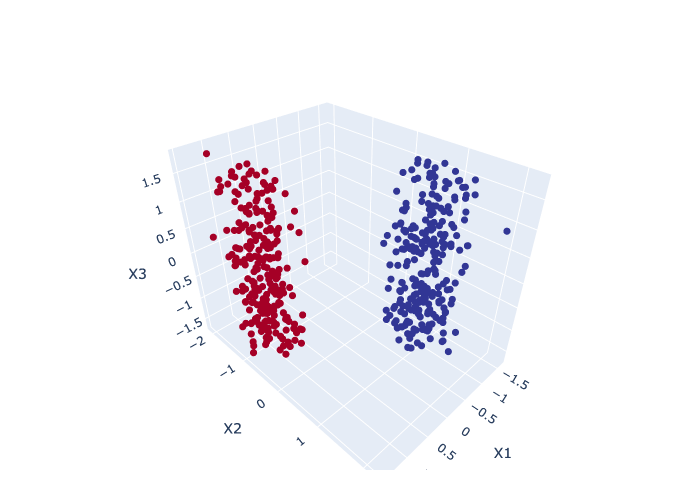

In [7]:
n_samples = 500
X, y = make_blobs(n_samples, n_features=2, centers=2, cluster_std=1, random_state=123)
X = np.concatenate((X, np.random.random((n_samples, 1))), axis=1)
X = StandardScaler().fit_transform(X)
plot_scatter3D(X, y)

- We can see that `X1` and `X2` split the data nicely, and the `X3` is just noise
- The question is, can an AE learn that this data can be nicely separated in just two of the three dimensions?
- Let's build a simple AE with the following neurons in each layer: 3 -> 2 -> 3:

In [8]:
class autoencoder(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 2),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [9]:
BATCH_SIZE = 100
torch.manual_seed(1)
X_tensor = torch.tensor(X, dtype=torch.float32)
dataloader = DataLoader(X_tensor,
                        batch_size=BATCH_SIZE)
model = autoencoder(3, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [10]:
EPOCHS = 5

for epoch in range(EPOCHS):
    for batch in dataloader:
        optimizer.zero_grad()           # Clear gradients w.r.t. parameters
        y_hat = model(batch)            # Forward pass to get output
        loss = criterion(y_hat, batch)  # Calculate loss
        loss.backward()                 # Getting gradients w.r.t. parameters
        optimizer.step()                # Update parameters

- We only care about the encoder now, does it represent our data nicely in reduced dimensions?

In [11]:
model.eval()
print(f"Original X shape = {X_tensor.shape}")
X_encoded = model.encoder(X_tensor)
print(f" Encoded X shape = {X_encoded.shape}")

Original X shape = torch.Size([500, 3])
 Encoded X shape = torch.Size([500, 2])


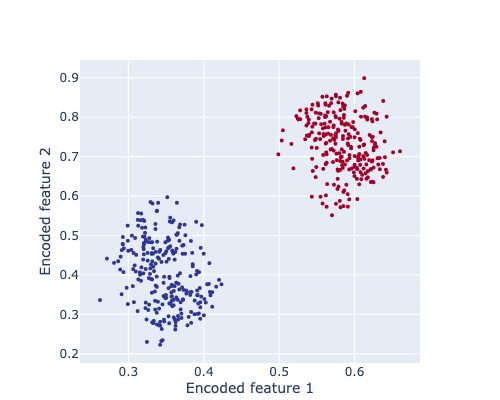

In [12]:
plot_scatter2D(X_encoded, y)

- What did we just do? We used an AE to effectively reduce the number of features in our data
- This is very similar to concepts of unsupervised learning and clustering that we'll discuss in DSCI 563.

### 2.2. Example 2: Image Denoising

- Okay, let's do something more interesting
- We saw above that AEs can be useful feature reducers (i.e., they can remove unimportant features from our data)
- This also applies to images and it's a fun application to de-noise images!
- Take a look at these images of 8's from the MNIST dataset, I'm going to mess them up by adding some noise to them:

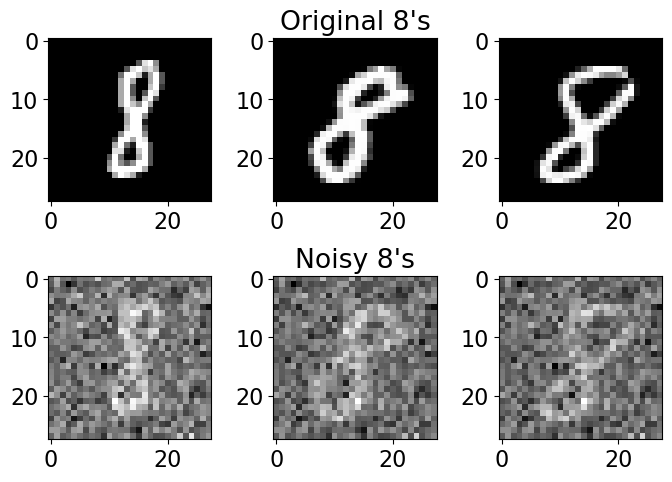

In [13]:
BATCH_SIZE = 32

# Download data
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST('data/', download=True, train=True, transform=transform)
idx = trainset.targets == 8  # let's only work with the number 8
trainset.targets = trainset.targets[idx]
trainset.data = trainset.data[idx]
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Sample plot
X, y = next(iter(trainloader))
noise = 0.5
plot_eights(X, noise)

In [14]:
X.shape

torch.Size([32, 1, 28, 28])

- Can we train an AE to get rid of that noise and reconstruct the original 8's? Let's give it a try!
- I'm going to use convolutional layers in my AE now as we are dealing with images
- We'll use `Conv2D()` layers to *compress* our images into a reduced dimensonality, and then we need to "upsample" it back to the original size
- One ingredient you'll need to know to do this is "transposed convolutional layers". These are just like "convolutional layers" but for the purpose of "upsampling" (increasing the size of) our data. Rather than simply expanding the size of our data and interpolating, we use 
`nn.ConvTranspose2d()` layers to help us learn how to best upsample our data:

![](img/conv_trans_1.gif)

![](img/conv_trans_2.gif)

Source: modified from [A guide to convolution arithmetic for deep learning, Vincent Dumoulin (2018)](https://arxiv.org/abs/1603.07285)

#### Convolution Layers

Convolution layers **downsample** input features. In other words, the goal of convolution layers is to go from **larger features (images)** to **smaller features (images)**.

Here is an animation of how kernels are applied to input features:

<img src="img/conv-padded.gif" width="200"><img src="img/conv-strided-padded.gif" width="200">
<br>
[(image source)](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

<br><br><br>

#### Transposed Convolution Layers

This is the first time we see transposed convolution layers. These layers do the opposite of what convolution layers do; that is, instead of downsampling images, they upsample. Transposed convolutions are used in the generator of a GAN to generate a image from some random vector.

The goal of transposed convolution layers is to go from **smaller features (images)** to **larger features (images)**.

<img src="img/conv-trans-strided.gif" width="200"><img src="img/conv-trans-not-strided.gif" width="200"><br>
[(image source)](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

While downsampling seems very intuitive, upsampling might look like doing magic: we try to generate information (pixel values) that did not exist before. But it's practically not hard to do.

We do something similar to what we did with convolution layers: we convolve (pass) the kernel over the inputs, and multiply each input element by all kernel elements. The resulting array will be part of the larger image:

<img src="img/conv-trans-how.svg" width="500"><br>
[(image source)](https://d2l.ai/chapter_computer-vision/transposed-conv.html)

If we repeat this operation in several layers, we can progressively increase the size of the input images. This is exactly what the generator does; it starts from some random noise, and progressively expands that into larger and larger images.

In [15]:
def conv_block(input_channels, output_channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)  # reduce x-y dims by two; window and stride of 2
    )

def deconv_block(input_channels, output_channels, kernel_size):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2),
        nn.ReLU()
    )

class autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(1, 32),
            conv_block(32, 16),
            conv_block(16, 8)
        )
        self.decoder = nn.Sequential(
            deconv_block(8, 8, 3),
            deconv_block(8, 16, 2),
            deconv_block(16, 32, 2),
            nn.Conv2d(32, 1, 3, padding=1)  # final conv layer to decrease channel back to 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)  # get pixels between 0 and 1
        return x

In [16]:
model = autoencoder()
summary(model, (1, 28, 28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 3, 3]             --
|    └─Sequential: 2-1                   [-1, 32, 14, 14]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 28, 28]          320
|    |    └─ReLU: 3-2                    [-1, 32, 28, 28]          --
|    |    └─MaxPool2d: 3-3               [-1, 32, 14, 14]          --
|    └─Sequential: 2-2                   [-1, 16, 7, 7]            --
|    |    └─Conv2d: 3-4                  [-1, 16, 14, 14]          4,624
|    |    └─ReLU: 3-5                    [-1, 16, 14, 14]          --
|    |    └─MaxPool2d: 3-6               [-1, 16, 7, 7]            --
|    └─Sequential: 2-3                   [-1, 8, 3, 3]             --
|    |    └─Conv2d: 3-7                  [-1, 8, 7, 7]             1,160
|    |    └─ReLU: 3-8                    [-1, 8, 7, 7]             --
|    |    └─MaxPool2d: 3-9               [-1, 8, 3, 3]             --
├─Sequen

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 8, 3, 3]             --
|    └─Sequential: 2-1                   [-1, 32, 14, 14]          --
|    |    └─Conv2d: 3-1                  [-1, 32, 28, 28]          320
|    |    └─ReLU: 3-2                    [-1, 32, 28, 28]          --
|    |    └─MaxPool2d: 3-3               [-1, 32, 14, 14]          --
|    └─Sequential: 2-2                   [-1, 16, 7, 7]            --
|    |    └─Conv2d: 3-4                  [-1, 16, 14, 14]          4,624
|    |    └─ReLU: 3-5                    [-1, 16, 14, 14]          --
|    |    └─MaxPool2d: 3-6               [-1, 16, 7, 7]            --
|    └─Sequential: 2-3                   [-1, 8, 3, 3]             --
|    |    └─Conv2d: 3-7                  [-1, 8, 7, 7]             1,160
|    |    └─ReLU: 3-8                    [-1, 8, 7, 7]             --
|    |    └─MaxPool2d: 3-9               [-1, 8, 3, 3]             --
├─Sequen

- So we want to train our model to remove that noise I added
- Generally speaking, the idea is that the model learns what pixel values are important, we are reducing the dimensionality of the imaages, so our model must learn only the crucial information (i.e., not the noise) needed to reproduce the image
- Right now, our model probably produces gibberish because it isn't trained:

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


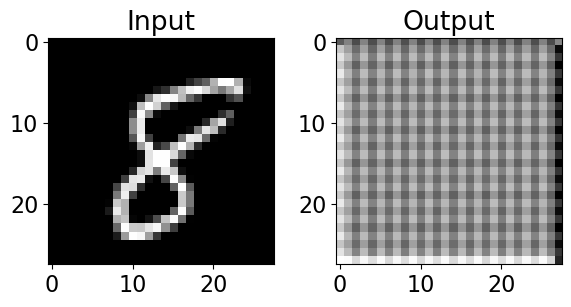

In [17]:
model = autoencoder()
input_8 = X[:1, :1, :, :]
output_8 = model(input_8)
plot_eight_pair(input_8, output_8)

- How do we train it?
- Well we feed in a noisy image, compare it to the non-noisy version, and let the network learn how to make that happen
- We want the value of the predicted pixels to be as close as possible to the real pixel values, so we'll use `MSELoss()` as our loss function:

In [18]:
EPOCHS = 20
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
img_list = []

for epoch in range(EPOCHS):
    losses = 0
    for batch, _ in trainloader:
        noisy_batch = batch + noise * torch.randn(*batch.shape)
        noisy_batch = torch.clip(noisy_batch, 0.0, 1.0)
        optimizer.zero_grad()
        y_hat = model(noisy_batch)
        loss = criterion(y_hat, batch)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"epoch: {epoch + 1}, loss: {losses / len(trainloader):.4f}")
    # Save example results each epoch so we can see what's going on
    with torch.no_grad():
        noisy_8 = noisy_batch[:1, :1, :, :]
        model_8 = model(input_8)
        real_8 = batch[:1, :1, :, :]
    img_list.append(utils.make_grid([noisy_8[0], model_8[0], real_8[0]], padding=1))

epoch: 1, loss: 0.1165
epoch: 2, loss: 0.0635
epoch: 3, loss: 0.0486
epoch: 4, loss: 0.0423
epoch: 5, loss: 0.0394
epoch: 6, loss: 0.0375
epoch: 7, loss: 0.0362
epoch: 8, loss: 0.0351
epoch: 9, loss: 0.0343
epoch: 10, loss: 0.0336
epoch: 11, loss: 0.0329
epoch: 12, loss: 0.0325
epoch: 13, loss: 0.0318
epoch: 14, loss: 0.0314
epoch: 15, loss: 0.0310
epoch: 16, loss: 0.0305
epoch: 17, loss: 0.0302
epoch: 18, loss: 0.0299
epoch: 19, loss: 0.0295
epoch: 20, loss: 0.0291


```C
epoch: 1, loss: 0.0914
epoch: 2, loss: 0.0501
epoch: 3, loss: 0.0431
...
epoch: 28, loss: 0.0275
epoch: 29, loss: 0.0273
epoch: 30, loss: 0.0273
```

In [ ]:
%%capture
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title("Input        Prediction        Actual")
ims = [[plt.imshow(np.transpose(i, (1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani.save('eights.gif', writer='imagemagick', fps=2)
# HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

![](img/eights.gif)

- Pretty cool!

<br><br><br><br>

## 3. Generative Adversarial Networks (GANs)


### 3.1 What are GANs?

GANs are a type of neural network models that are used to generate new data, that is indistinguishable from the data that exists in a dataset.

For example, suppose that we have a dataset of 10,000 images. The question is: can we somehow generate images that are so real-looking that we can't tell if they are **real** (could potentially come from the dataset) or **fake** (generated by some algorithm)?

Here, there aren't any real labels. We just want to be able to produce images that are as real-looking as possible; we don't classify them. This is why **GAN modeling** is regarded as an **unsupervised learning** task. In other words, we just need a bunch of images (or input data), no labels (or target data or outputs) would be required. We will learn more on unsupervised learning in DSCI 563.

<br><br><br>

GANs were invented in 2014 by Ian Goodfellow and colleagues (see the original paper [here](https://arxiv.org/abs/1406.2661)); and have been called "_the most interesting idea in the last 10 years in ML_" by Yann LeCun, Facebook’s AI research director.

<br><br><br>

Now take a look at the following image:

<img src="img/GAN-face.png" width="400">


Believe it or not, **this is not a real person!**

The image above is produced by a GAN that is trained on human faces. If you want to see more, visit [www.thispersondoesnotexist.com](www.thispersondoesnotexist.com). The website is connected to a GAN model living on the cloud, and each time the page refreshes, it generates a new image of a person who **does not exist!**.

<br><br><br>

### 3.2 Structure of a GAN



![](img/GAN-structure.png)

[Source](https://developers.google.com/machine-learning/gan/gan_structure)

In this section, I describe how GANs work for image data, but remember that the idea of GANs is generalizable to any kind of data, not just images.

Here is the visualization of the structure of a GAN:

<img src="img/gan-1.png" width="900"><br>
[(image source)](https://freecontent.manning.com/practical-applications-of-gans-part-1/)

The structure of a GAN consists of a **discriminator** and a **generator**:

- A discriminator is just a **typical CNN** that receives an image as the input, and generates a vector of probabilities of the input belonging to some class

- A generator is an **inverted CNN** that receives a vector of random numbers and generates an image in the output

<br><br><br>

The word "adversarial" comes from the fact that we actually have two networks battling each other:

- The generator: tries to generate fake images that look as realistic as possible such that it can **fool** the discriminator

- The discriminator: takes in real data and fake data and tries to correctly determine whether an input was real or fake

<br><br><br>

**An analogy:**

Think of the "Generator" as a new counterfeit artist trying to produce realistic-looking famous artworks to sell.

The "Discriminator" is an art critic, trying to determine if a piece of art is "real" or "fake".

At first, the "Generator" produces poor art-replicas which the "Discriminator" can easily tell are fake. But over time, the "Generator" learns ways to produce art that fools the "Discriminator". Eventually, the "Generator" becomes so good that the "Discriminator" can't tell if a piece of art is real or fake.

<br><br><br>

### 3.3 Training GANs

Training a GAN happens in two iterative phases:

1. **Train the Discriminator:**

    - Generate some fake images with the generator
    
    - Show the discriminator real images and fake images and get it to classify them correctly (a simple binary classification problem)

2. **Train the Generator:**

    - Generate fake images with the generator but label them as "real"
    
    - Pass these fake images through the discriminator, and ask it for its judgment, i.e. the probability of this image being real
    - Pass this judgment to a loss function, and see how far it is from the ideal output. The ideal output is that the generator was so good that it has fooled the discriminator to give it the label of "real".
    - Do backpropagation based on the gradients of this loss value to adjust the parameters of the generator, such that it can better and better fool the discriminator.

3. **Repeat**.

<br><br><br>

<img src="img/gan-train.png" width="600"><br>
[(image source)](https://sthalles.github.io/intro-to-gans/)

<br><br><br>

### 3.4 PyTorch Implementation

Alright, now's the time to implement a GAN in PyTorch. Since training GANs is a very resource-intensive job, we need to do our computations on a GPU. Here, I'll write the code **so that you can take this notebook and run it directly on [Kaggle](https://www.kaggle.com)**. If you want to run it on your own computer, you need to change the folder paths of the dataset that we're going to use.

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: mps


For the purpose of demonstrating how training a GAN works in PyTorch, we'll use the [Face Recognition Dataset_](https://www.kaggle.com/stoicstatic/face-recognition-dataset) from Kaggle, which contains face images of celebrities.

This dataset contains two folders: `Face Dataset` and `Extracted Faces`. We'll use the images in `Extracted Faces`, which are already `128x128` pixels. Therefore, there is no need to resize them, which is why I've commented out `transforms.Resize(IMAGE_SIZE)` in the code below. This speeds up the computations significantly, as resizing is done on CPU and it would have been the bottle-neck of our computations. Fortunately, we don't need to do this here:

In [23]:
DATA_DIR = "../input/face-recognition-dataset/Extracted Faces"

BATCH_SIZE = 64
IMAGE_SIZE = (128, 128)

data_transforms = transforms.Compose([
#     transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root=DATA_DIR, transform=data_transforms)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
        
# Plot samples
sample_batch = next(iter(data_loader))
plt.figure(figsize=(8, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True), (1, 2, 0)));

print(f'Size of dataset: {len(data_loader) * BATCH_SIZE}')

Example output:

<img src="img/faces.png" width="500">

<br><br><br>

#### 3.4.1 Creating the Generator

The generator takes in a random vector called **latent vector**, which can be thought of as a `1x1` pixel image having an arbitrary number of **channels** (specified in the code by `LATENT_SIZE`).

Through the generator, we pass this latent vector through the **deconvolution** layers (known as **transposed convolution** layers in PyTorch), and progressively expand its size, such that in the output we'll have an image similar in dimensions to the images in our dataset. Here for example, our images in the dataset are `128x128`, so the goal of the generator is to start from an image of `1x1` pixel and generate an image of `128x128` pixels.

**Details:**

- In the following code, I've used `nn.BatchNorm2d()` for all layers, `nn.LeakyReLU()` as activation for intermediate layers, and `nn.Tanh()` as activation for the output of the generator. These are suggested to be used based on empirical evidence in training GANs.

- We usually do in-place modification of tensors in `nn.LeakyReLU()` by setting `inplace=True` to save some memory.
- We set `bias=False` because the batch normalization layer contains a bias term, so we don't want to do it twice.

Note that we mainly play with the strides to progressively expand the size of the input latent vector.

Here is the code for the generator:

In [24]:
class Generator(nn.Module):
    
    def __init__(self, LATENT_SIZE):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            # input dim: [-1, LATENT_SIZE, 1, 1]
            # output size = (1 - 1)*1 - 2*0 + 4
            
            nn.ConvTranspose2d(LATENT_SIZE, 1024, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 1024, 4, 4]
            # output size = (input size - 1)*stride - 2*padding + kernel size
            # (4 - 1)*2 - 2 * 1 + 4 = 4 + 4 = 8

            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 512, 8, 8]

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 256, 16, 16]

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 128, 32, 32]
            
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            
            # output dim: [-1, 64, 64, 64]

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(3),
            
            # output dim: [-1, 3, 128, 128]
            
            nn.Tanh()
            
            # output dim: [-1, 3, 128, 128]
        )
        
    def forward(self, input):
        output = self.main(input)
        return output

<br><br><br>

The details of how exactly a transposed convolution layer works in PyTorch can be fairly confusing at first, but here's some further remarks to help you feel more comfortable with it:

The parameters `stride` and `padding` in `nn.ConvTranspose2d` are (unfortunately?) not what we’re used to in using `nn.Conv2d`. For example, `stride=2` doesn’t mean that the kernel in the transposed convolution moves in steps of 2 pixels each time. These parameters are, instead, designed such that if you use the same stride and padding for a `ConvTranspose2d` as in a `Conv2d`, and apply it on the output of the that `Conv2d`, it will give you an image of the same shape (but not the same pixel values). 

If you’re wondering about the mechanics of computing a transposed convolution in various scenarios, **make sure to check out [this article](https://arxiv.org/pdf/1603.07285.pdf) or [this blog post](https://numbersmithy.com/understanding-transposed-convolutions-in-pytorch/).**

<br><br><br>

#### 3.4.2 Creating the Discriminator

As discussed before, this is a conventional CNN that receives an image (`128x128` in our case here) and outputs the probability of this image belonging to some certain class:

- Using pooling layers is less common because they reduce spatial resolution of feature maps and can result in loss of fine-grained details
- It's more common to use strided convolutions instead
- We usually do in-place modification of tensors in `nn.LeakyReLU()` by setting `inplace=True` to save some memory.
- We set `bias=False` because the batch normalization layer contains a bias term, so we don't want to do it twice.

In [25]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
        
            # input dim: [-1, 3, 128, 128]
            
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 64, 64]

            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 64, 32, 32]

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 128, 16, 16]

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 256, 8, 8]

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            # output dim: [-1, 512, 4, 4]

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            
            # output dim: [-1, 1, 1, 1]

            nn.Flatten(),
            
            # output dim: [-1]

            nn.Sigmoid()
            
            # output dim: [-1]
        )

    def forward(self, input):
        output = self.main(input)
        return output

<br><br><br>

#### Instantiating and Initializing our GAN

Let's create the discriminator and generator objects, as well as the loss function and optimizers:

In [28]:
LATENT_SIZE = 200

generator = Generator(LATENT_SIZE)
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

criterion = nn.BCELoss()

optimizerG = optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

<br><br><br>

We explored how the starting point of the optimization can affect the final results. It is recommended that to initialize the weights of a GAN with values obtained randomly from a normal distribution. In PyTorch, we can define the initialization function as we like and apply it to the model parameters using the `.apply()` method:

In [29]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
generator.apply(weights_init)
discriminator.apply(weights_init);

<br><br><br>

#### 3.4.1 Training our GAN

We use the following cell to keep track of how a fixed noise (latent vector) is transformed to a generated image in each epoch. We will see that the generations become better and better throughout the epochs:

In [ ]:
img_list = []
fixed_noise = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1).to(device)

Finally, here is the training loop (you can also put everything inside a function):

In [ ]:
NUM_EPOCHS = 50
from statistics import mean
print('Training started:\n')

D_real_epoch, D_fake_epoch, loss_dis_epoch, loss_gen_epoch = [], [], [], []

for epoch in range(NUM_EPOCHS):

    # D_real_iter: list that accumulates the average output of the discriminator 
    # for real images for each batch. High values mean the discriminator is more 
    # confidently classifying real images as real.

    # D_fake_iter: Similar to D_real_iter but for fake images. Low values indicate
    # the descriminator is confidently classifying them as fake. 
    
    # loss_dis_iter: Stores the discriminator loss for each batch. 
    # This is the sum of the loss on real images and the loss on fake images. 
    # Monitoring this helps understand how well the discriminator is 
    # differentiating between real and fake images.

    # loss_gen_iter: Stores the generator loss for each batch. This indicates 
    # how well the generator is fooling the discriminator. 
    
    D_real_iter, D_fake_iter, loss_dis_iter, loss_gen_iter = [], [], [], []
    
    for real_batch, _ in data_loader:

        # STEP 1: train discriminator
        # ==================================
        # Train with real data
        optimizerD.zero_grad()
        
        real_batch = real_batch.to(device)
        real_labels = torch.ones((real_batch.shape[0],), dtype=torch.float).to(device)
        
        output = discriminator(real_batch).view(-1)
        loss_real = criterion(output, real_labels)
        
        # Iteration book-keeping
        D_real_iter.append(output.mean().item())
        
        # Train with fake data
        noise = torch.randn(real_batch.shape[0], LATENT_SIZE, 1, 1).to(device)
        
        fake_batch = generator(noise)
        fake_labels = torch.zeros_like(real_labels)
        
        output = discriminator(fake_batch.detach()).view(-1)
        loss_fake = criterion(output, fake_labels)
        
        # Update discriminator weights
        loss_dis = loss_real + loss_fake
        loss_dis.backward()
        optimizerD.step()
        
        # Iteration book-keeping
        loss_dis_iter.append(loss_dis.mean().item())
        D_fake_iter.append(output.mean().item())
        
        # STEP 2: train generator
        # ==================================
        optimizerG.zero_grad()

        # Calculate the output with the updated weights of the discriminator
        output = discriminator(fake_batch).view(-1)
        loss_gen = criterion(output, real_labels)
        loss_gen.backward()
        
        # Book-keeping
        loss_gen_iter.append(loss_gen.mean().item())
        
        # Update generator weights and store loss
        optimizerG.step()
        
    print(f"Epoch ({epoch + 1}/{NUM_EPOCHS})\t",
          f"Loss_G: {mean(loss_gen_iter):.4f}",
          f"Loss_D: {mean(loss_dis_iter):.4f}\t",
          f"D_real: {mean(D_real_iter):.4f}",
          f"D_fake: {mean(D_fake_iter):.4f}")
    
    # Epoch book-keeping
    loss_gen_epoch.append(mean(loss_gen_iter))
    loss_dis_epoch.append(mean(loss_dis_iter))
    D_real_epoch.append(mean(D_real_iter))
    D_fake_epoch.append(mean(D_fake_iter))
    
    # Keeping track of the evolution of a fixed noise latent vector
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        #img_list.append(utils.make_grid(fake_images, normalize=True, nrows=10))
        
print("\nTraining ended.")

Example output:

```
Epoch (1/50)	 Loss_G: 16.1643 Loss_D: 2.7680	 D_real: 0.8808 D_fake: 0.1760
Epoch (2/50)	 Loss_G: 5.1395 Loss_D: 1.2464	 D_real: 0.7797 D_fake: 0.2442
Epoch (3/50)	 Loss_G: 2.3695 Loss_D: 1.3886	 D_real: 0.6162 D_fake: 0.3758
Epoch (4/50)	 Loss_G: 2.3272 Loss_D: 1.3902	 D_real: 0.6065 D_fake: 0.3902
Epoch (5/50)	 Loss_G: 2.4110 Loss_D: 1.2522	 D_real: 0.6205 D_fake: 0.3870
Epoch (6/50)	 Loss_G: 2.6082 Loss_D: 1.2582	 D_real: 0.6301 D_fake: 0.3727
Epoch (7/50)	 Loss_G: 2.3240 Loss_D: 1.2784	 D_real: 0.6152 D_fake: 0.3882
Epoch (8/50)	 Loss_G: 2.3167 Loss_D: 1.3681	 D_real: 0.6032 D_fake: 0.3983
Epoch (9/50)	 Loss_G: 2.3370 Loss_D: 1.2700	 D_real: 0.6068 D_fake: 0.3959
Epoch (10/50)	 Loss_G: 2.3772 Loss_D: 1.2815	 D_real: 0.6077 D_fake: 0.3872
```

During the training of the discriminator in a GAN, it is important to prevent updates to the generator's parameters. This is achieved in the code by using the `detach()` method on the `fake_batch`. When `detach()` is applied to a tensor in PyTorch, it creates a new tensor that is disconnected from the current computation graph, meaning that it does not track gradients. Consequently, when `fake_batch.detach()` is used in our code, it instructs PyTorch not to calculate gradients for the generator during the discriminator's backward pass. Without `detach()`, gradients from the discriminator's loss, when evaluating fake images, would propagate back through both the discriminator and the generator, which is not desirable during this phase of training.

Here's the relevant part of the code for training the discriminator with fake data:

```python
output = discriminator(fake_batch.detach()).view(-1)
loss_fake = criterion(output, fake_labels)
```

On the other hand, in the generator training phase, the objective is to update the generator's parameters such that it becomes better at generating images. Here, the gradients need to flow through both the discriminator and the generator. This is why `detach()` is not used when passing `fake_batch` to the discriminator. 

Here's the code segment for training the generator:

```python
output = discriminator(fake_batch).view(-1)
loss_gen = criterion(output, real_labels)
```

<br><br><br>

#### 3.4.2 Visualizing Training Progress

The following plots will help you see how the loss values of the generator and the discriminator, as well as the probabilities generated by the discriminator on real and fake images evolve during the training of our GAN:

In [ ]:
plt.plot(np.array(loss_gen_epoch), label='loss_gen')
plt.plot(np.array(loss_dis_epoch), label='loss_dis')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend();

Example output:

<img src="img/loss_epoch.png" width="350">

In [ ]:
plt.plot(np.array(D_real_epoch), label='D_real')
plt.plot(np.array(D_fake_epoch), label='D_fake')
plt.xlabel("Epoch")
plt.ylabel("Probability")
plt.legend();

Example output:

<img src="img/D_epoch.png" width="350">

<br><br><br>

The following code cells help to see the evolution of one fixed noise vector throughout the epochs. The generator is applied on this fixed random noise in each epoch, and the results are saved as batches of generated images.

In [ ]:
%%capture

fig = plt.figure(figsize=(10, 10))
ims = [[plt.imshow(np.transpose(i,(1, 2, 0)), animated=True)] for i in img_list[::1]]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('GAN.gif', writer='imagemagick', fps=2)

In [ ]:
HTML(ani.to_jshtml()) # run this in a new cell to produce the below animation

These are my results after running the GAN model for around 100 epochs:

<img src="img/GAN.gif" width="600"><br>

**Note:** You might have noticed the checker-board patterns that appear in the generated images, especially early in the training process. This is a known issue with transposed convolutions. This problem and potential solutions are discussed in great detail in [this article](https://distill.pub/2016/deconv-checkerboard/).

 Here is a picture of GAN training from the original [paper](https://arxiv.org/abs/1406.2661). 

- Data generating distribution $\rightarrow$ Green solid line
- Real data distribution $\rightarrow$ black dotted line
- Discriminator distribution $\rightarrow$ Blue dashed line
- Lower horizontal line $\rightarrow$ domain from which $z$ is sampled (uniform distribution in this case)

![](img/GAN-plots.png)

[Source](https://arxiv.org/abs/1406.2661)

- (a) Initially we have a partially accurate classifier 
- (b) After training the discriminator for a few epochs it is able to classify real vs. fake examples. 
- (c) The gradient of the discriminator guides the generator to move to the real data distribution 
- (d) After several steps of training, if the generator distribution and the real data distribution align. The discriminator is unable to differentiate between the two distributions. 

<br><br><br><br>

## 4. Multi-input Networks
<hr>

- Sometimes you'll want to combine different types of data in a single network
- The most common case is combining tabular data with image data, for example, using both real estate data and images of a house to predict its sale price:

![](img/multi-input.png)

Source: "[House](https://www.flickr.com/photos/68089229@N06/17458373552)" by [oatsy40](https://www.flickr.com/photos/68089229@N06), "[House in Vancouver](https://www.flickr.com/photos/17573364@N00/433449690)" by [pnwra](https://www.flickr.com/photos/17573364@N00), "[House](https://www.flickr.com/photos/21098413@N04/5405425139)" by [noona11](https://www.flickr.com/photos/21098413@N04) all licensed under [CC BY 2.0](https://creativecommons.org/licenses/by/2.0/?ref=ccsearch&atype=rich).

- In such a problem you may want to combine:
    1. a NN for the tabular data
    2. a CNN for the image data
- The way we often do this is create these two models, and then combine them together into a model that produces a single output
- This sounds complicated but it's pretty easy! We only need one new ingredient which is a concatenation function: `torch.cat()`
- Below is a simple example:

In [30]:
class MultiModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 8, 5, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1800, 5)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 5)
        )
        
        self.multi = nn.Sequential(
            nn.Linear(10, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        
    def forward(self, image, data):
        x_cnn = self.cnn(image)
        x_fc = self.fc(data)
        x_multi = torch.cat((x_cnn, x_fc), dim=1)
        return self.multi(x_multi)

In [ ]:
model = MultiModel()
image = torch.randn(1, 3, 64, 64)
data = torch.randn(1, 10)
model(image, data).item()

- The above network doesn't really do anything but show that we can easily combine a CNN and fully connected NN!

<br><br><br><br>

## 5. Conclusion

How did we do with the course learning objectives? 

- Identify common computational issues caused by floating-point arithmatic, e.g., rounding, overflow, etc., and program defensively against these errors.
- Explain how the gradient descent algorithm and its variants work.
- Explain the fundamental concepts of neural networks including layers, nodes, and activation functions and gain proficiency in implementing basic neural networks using `PyTorch`.  
- Illustrate the process of backpropagation in neural network training. 
- Explain how convolutional neural networks work and implement them for image classification using PyTorch. 
- Explain and apply transfer learning and the different flavours of it: "out-of-the-box", "feature extractor", "fine tuning".
- Describe at a high level the basic principles and architecture of Generative Adversarial Networks (GANs)


### Coming up ...

- Clustering, dimensionality reduction, word embeddings, recommender systems (DSCI 563)
- Training at scale/distributed computing (coming in DSCI 525)
- Working with other forms of data like time series (DSCI 574)
- Markov models, topic modeling, recurrent neural networks, and transformers (DSCI 575)


### Final remarks 

I hope you learned something useful from the course. I was teaching this course for the first time and I had fun teaching this material to you! 

Here are fake versions of you, me, and our classroom 😀. (I also see some strawberries in the picture although they were not in the prompt 🍓🍓.) I generated this image by DALL-E, an AI image creation tool, using the following prompt.  

> Generate a high-resolution photo of a computer science professor thanking her students for the term and wishing them luck on the upcoming quizzes and blocks ... Happy vibes and nice lighting.

![](img/Dalle-CS-prof.png)

FYI: The online course evaluations are up, it'll be great if you can fill them in when you get a chance. 

https://canvas.ubc.ca/courses/123600/external_tools/4732